In [ ]:
pip install skforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.8/424.8 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.4.0
    Uninstalling joblib-1.4.0:
      Successfully uninstalled joblib-1.4.0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error, mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import random_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.preprocessing import StandardScaler
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from sklearn.preprocessing import FunctionTransformer
%matplotlib inline
plt.style.use('seaborn')

<ipython-input-2-8d776a0bd691>:28: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filePath = '/content/drive/MyDrive'

# Carga de variables obtenidas del dataset satelital y ajuste de las mismas para el programa ETo Calculator

In [ ]:
#df_time_series_PET = pd.read_csv(f'{filePath}/Finca_SanLuis_dataset_variables_ETo_2015_2024.csv')
df_time_series_var = pd.read_excel(f'{filePath}/Finca_SanLuis_dataset_variables_satel_ETo_2015_2024.xlsx',dtype={'Band_value_dewpoint_tempereature_2m_min': 'str', 'Bandvalue_dewpoint_temperature_2m_max': 'str', 'Bandvalue_temperature_2m_min': 'str', 'Bandvalue_temperature_2m_max': 'str', 'Bandvalue_temperature_2m': 'str', 'Bandvalue_dewpoint_temperature_2m': 'str','Bandvalue_u_component_of_wind_10m': 'str','Bandvalue_u_component_of_wind_10m_min':'str','Bandvalue_u_component_of_wind_10m_max':'str','Bandvalue_surface_solar_radiation_downwards_sum':'str'})

NameError: name 'pd' is not defined

In [ ]:
df_time_series_var.info()

In [ ]:
df_time_series_var

In [ ]:
df_time_series_var_sat=df_time_series_var.copy()
df_time_series_var_sat['date'] = pd.to_datetime(df_time_series_var_sat['Bandname_dewpoint_tempereature_2m_min'], format='%Y%m%d_dewpoint_temperature_2m_min')
df_time_series_var_sat=df_time_series_var_sat.drop(['Bandname_dewpoint_tempereature_2m_min'],axis=1)
df_time_series_var_sat

In [ ]:
print("Number of missing values: ", df_time_series_var_sat.isnull().sum().sum())
print("Número de valores na: "),df_time_series_var_sat.isna().sum()

In [ ]:
columns_to_process = ['Band_value_dewpoint_tempereature_2m_min', 'Bandvalue_dewpoint_temperature_2m_max', 'Bandvalue_temperature_2m_min', 'Bandvalue_temperature_2m_max', 'Bandvalue_temperature_2m', 'Bandvalue_dewpoint_temperature_2m']
def pad_with_zeros(value):
    if '.' in value:
      value =value.replace('.','')
      return value.ljust(6,'0')
    return value

def to_float_3dec(value):
    valueint=value[:3]
    valuedec=value[3:]
    value=valueint + '.' + valuedec
    return value

def kelvin_to_celsius(value):
    value = value - 273.15
    return value

for col in columns_to_process:
    df_time_series_var_sat[col] = df_time_series_var_sat[col].apply(pad_with_zeros)
    df_time_series_var_sat[col] = df_time_series_var_sat[col].apply(to_float_3dec)
    df_time_series_var_sat[col] = df_time_series_var_sat[col].astype(float)
    df_time_series_var_sat[col] = df_time_series_var_sat[col].apply(kelvin_to_celsius)
    df_time_series_var_sat[col] = df_time_series_var_sat[col].round(2)


In [ ]:
df_time_series_var_sat.info()

In [ ]:
df_time_series_var_sat.head(11)

In [ ]:
def remove_char(value):
    if '.' in value:
      value =value.replace('.','')
      return value
    return value

def to_float_int(value):
    valueint=value[:1]
    valuedec=value[1:]
    value=valueint + '.' + valuedec
    return value
df_time_series_var_sat['Bandvalue_u_component_of_wind_10m_max'] = df_time_series_var_sat['Bandvalue_u_component_of_wind_10m_max'].apply(remove_char)
df_time_series_var_sat['Bandvalue_u_component_of_wind_10m_max'] = df_time_series_var_sat['Bandvalue_u_component_of_wind_10m_max'].apply(to_float_int)
df_time_series_var_sat['Bandvalue_u_component_of_wind_10m_max'] = df_time_series_var_sat['Bandvalue_u_component_of_wind_10m_max'].astype(float)
df_time_series_var_sat['Bandvalue_u_component_of_wind_10m_max'] = df_time_series_var_sat['Bandvalue_u_component_of_wind_10m_max'].round(2)

In [ ]:
df_time_series_var_sat['Bandvalue_surface_solar_radiation_downwards_sum'] = df_time_series_var_sat['Bandvalue_surface_solar_radiation_downwards_sum'].str.replace(',','')
df_time_series_var_sat['Bandvalue_surface_solar_radiation_downwards_sum'] = df_time_series_var_sat['Bandvalue_surface_solar_radiation_downwards_sum'].astype(float)
def joules_to_megajoules(energy_joules):
    energy_megajoules = energy_joules / 1e6
    return energy_megajoules
df_time_series_var_sat['Bandvalue_surface_solar_radiation_downwards_sum'] = df_time_series_var_sat['Bandvalue_surface_solar_radiation_downwards_sum'].apply(joules_to_megajoules)
df_time_series_var_sat['Bandvalue_surface_solar_radiation_downwards_sum'] = df_time_series_var_sat['Bandvalue_surface_solar_radiation_downwards_sum'].round(2)


In [ ]:
def calculate_relative_humidity(dew_point, temperature):
    # Calculate saturation vapor pressure at dew point temperature
    es_dew_point = 0.6108 * np.exp((17.27 * dew_point) / (dew_point + 237.3))

    # Calculate saturation vapor pressure at air temperature
    es_air_temp = 0.6108 * np.exp((17.27 * temperature) / (temperature + 237.3))

    # Calculate relative humidity
    relative_humidity = (es_dew_point / es_air_temp) * 100

    return relative_humidity

df_time_series_var_sat['relative_humidity'] = calculate_relative_humidity(df_time_series_var_sat['Bandvalue_dewpoint_temperature_2m'],df_time_series_var_sat['Bandvalue_temperature_2m'])
df_time_series_var_sat['relative_humidity'] = df_time_series_var_sat['relative_humidity'].round(2)

In [ ]:
df_time_series_var_sat_trans= df_time_series_var_sat.drop(['Band_value_dewpoint_tempereature_2m_min','Bandvalue_dewpoint_temperature_2m_max','Bandvalue_temperature_2m','Bandvalue_dewpoint_temperature_2m','Bandvalue_u_component_of_wind_10m','Bandvalue_u_component_of_wind_10m_min'],axis=1)
df_time_series_var_sat_trans

In [ ]:
df_time_series_var_sat_trans.info()

In [ ]:
df_time_series_var_sat_trans.to_csv('dataset_variables_Finca_Sanluis_input_ETo_calculator.csv')

In [ ]:
def calculate_eto(latitude, altitude, tmax, tmin, solar_rad, wind_speed, rh_max, rh_min):
    # Convert latitude from degrees to radians
    latitude_rad = np.radians(latitude)

    # Calculate delta (slope of the vapor pressure curve)
    delta = 4098 * (0.6108 * np.exp(17.27 * tmax / (tmax + 237.3))) / ((tmax + 237.3) ** 2)

    # Calculate the mean temperature
    tmean = (tmax + tmin) / 2.0

    # Calculate the extraterrestrial radiation (Ra) - FAO-56
    dr = 1 + 0.033 * np.cos(2 * np.pi / 365.0 * doy)
    delta_solar_declination = 0.409 * np.sin(2 * np.pi / 365.0 * doy - 1.39)
    omega = np.arccos(-np.tan(latitude_rad) * np.tan(delta_solar_declination))
    Ra = (24 * 60 / np.pi) * 0.082 * dr * (omega * np.sin(latitude_rad) * np.sin(delta_solar_declination) +
                                           np.cos(latitude_rad) * np.cos(delta_solar_declination) * np.sin(omega))

    # Convert solar radiation from MJ/m^2/day to J/m^2/day
    solar_rad = solar_rad * 1e6

    # Calculate net outgoing longwave radiation (Rnl)
    emissivity = 0.34 - 0.14 * np.sqrt(ea)
    rns = (1 - albedo) * solar_rad
    sigma = 4.903 * 1e-9  # Stefan-Boltzmann constant in MJ K^-4 m^-2 day^-1
    rnl = sigma * (tmax + 273.16) ** 4 * (0.34 - 0.14 * np.sqrt(ea)) * (1.35 * solar_rad / Ra - 0.35)

    # Calculate net radiation (Rn)
    rn = rns - rnl

    # Calculate saturation vapor pressure (es) and actual vapor pressure (ea)
    es_tmax = 0.6108 * np.exp((17.27 * tmax) / (tmax + 237.3))
    es_tmin = 0.6108 * np.exp((17.27 * tmin) / (tmin + 237.3))
    es = (es_tmax + es_tmin) / 2.0  # Average saturation vapor pressure
    ea = (es_tmax * (rh_min / 100.0) + es_tmin * (rh_max / 100.0)) / 2.0  # Average actual vapor pressure

    # Calculate psychrometric constant (gamma)
    gamma = 0.665 * 1e-3 * (pressure)

    # Calculate slope of the saturation vapor pressure curve (delta)
    delta = (4098 * es) / ((tmean + 237.3) ** 2)

    # Calculate ETo (FAO Penman-Monteith)
    numerator = 0.408 * delta * (rn - 0) + gamma * (900 / (tmean + 273)) * wind_speed * (es - ea)
    denominator = delta + gamma * (1 + 0.34 * wind_speed)
    eto = numerator / denominator

    return eto

In [ ]:
# Example usage
latitude =
altitude
tmax
tmin
solar_rad
wind_speed

temperature = 19.7  # Air temperature in Celsius
relative_humidity = calculate_relative_humidity(dew_point, temperature)
print("Relative Humidity:", relative_humidity)

# Carga Archivo ETo

In [ ]:
df_time_series_ETo_var = pd.read_excel(f'{filePath}/ETo_Finca_SanLuis_EToCalculator_2015_2024_report.xlsx')

In [ ]:
df_time_series_ETo_var

,Day,Month,Year,Tmax(C),Tmin(C),Rhmean(%),u(x)(m/sec),Rs(MJ/m2.day),Eto(mm/day),e(act)kPa,e(sat)kPa,u2(m/sec),Ra(MJ/m2.day),n(hour/day),N(hour/day),Rs(MJ/m2.day).1,Rnl(MJ/m2.day),Rn(MJ/m2.day)
0,1,1,2015,25.6,15.2,52.1,1.24,24.11,4.3,1249.0,2505,0.93,33.48,11.01,11.71,24.11,6.13,12.44
1,2,1,2015,26.1,14.8,50.2,1.44,24.45,4.4,1207.0,2532,1.08,33.50,11.23,11.71,24.45,6.33,12.49
2,3,1,2015,26.5,14.6,46.1,1.45,24.91,4.5,1115.0,2562,1.08,33.53,11.54,11.71,24.91,6.71,12.47
3,4,1,2015,26.4,14.3,45.0,1.50,25.04,4.6,1075.0,2536,1.12,33.57,11.62,11.71,25.04,6.82,12.46
4,5,1,2015,25.3,13.6,48.2,1.49,23.13,4.2,1089.0,2391,1.11,33.60,10.27,11.71,23.13,6.00,11.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3290,4,1,2024,26.3,15.7,68.0,1.30,23.31,4.2,1691.0,2603,0.97,33.57,10.41,11.71,23.31,5.05,12.90
3291,5,1,2024,25.6,15.2,70.7,1.38,21.77,3.9,1695.0,2505,1.03,33.60,9.32,11.71,21.77,4.53,12.23
3292,6,1,2024,26.9,14.2,56.5,1.42,24.59,4.4,1367.0,2582,1.06,33.64,11.27,11.71,24.59,6.02,12.91
3293,7,1,2024,26.9,15.1,50.0,1.39,24.39,4.5,1244.0,2630,1.04,33.67,11.11,11.71,24.39,6.24,12.54


In [ ]:
df_time_series_ETo = df_time_series_ETo_var[['Day','Month','Year','Eto(mm/day)']]
df_time_series_ETo

,Day,Month,Year,Eto(mm/day)
0,1,1,2015,4.3
1,2,1,2015,4.4
2,3,1,2015,4.5
3,4,1,2015,4.6
4,5,1,2015,4.2
...,...,...,...,...
3290,4,1,2024,4.2
3291,5,1,2024,3.9
3292,6,1,2024,4.4
3293,7,1,2024,4.5


In [ ]:
df_time_series_ETo['Date'] = pd.to_datetime(df_time_series_ETo[['Year', 'Month', 'Day']])
df_time_series_ETo

<ipython-input-8-f802543c6dda>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_series_ETo['Date'] = pd.to_datetime(df_time_series_ETo[['Year', 'Month', 'Day']])


,Day,Month,Year,Eto(mm/day),Date
0,1,1,2015,4.3,2015-01-01
1,2,1,2015,4.4,2015-01-02
2,3,1,2015,4.5,2015-01-03
3,4,1,2015,4.6,2015-01-04
4,5,1,2015,4.2,2015-01-05
...,...,...,...,...,...
3290,4,1,2024,4.2,2024-01-04
3291,5,1,2024,3.9,2024-01-05
3292,6,1,2024,4.4,2024-01-06
3293,7,1,2024,4.5,2024-01-07


In [ ]:
df_time_series_ETo = df_time_series_ETo.set_index('Date')
df_time_series_ETo = df_time_series_ETo.asfreq('d')
df_time_series_ETo = df_time_series_ETo.drop(['Day','Month','Year'],axis=1)

In [ ]:
df_time_series_ETo

,Eto(mm/day)
Date,
2015-01-01,4.3
2015-01-02,4.4
2015-01-03,4.5
2015-01-04,4.6
2015-01-05,4.2
...,...
2024-01-04,4.2
2024-01-05,3.9
2024-01-06,4.4


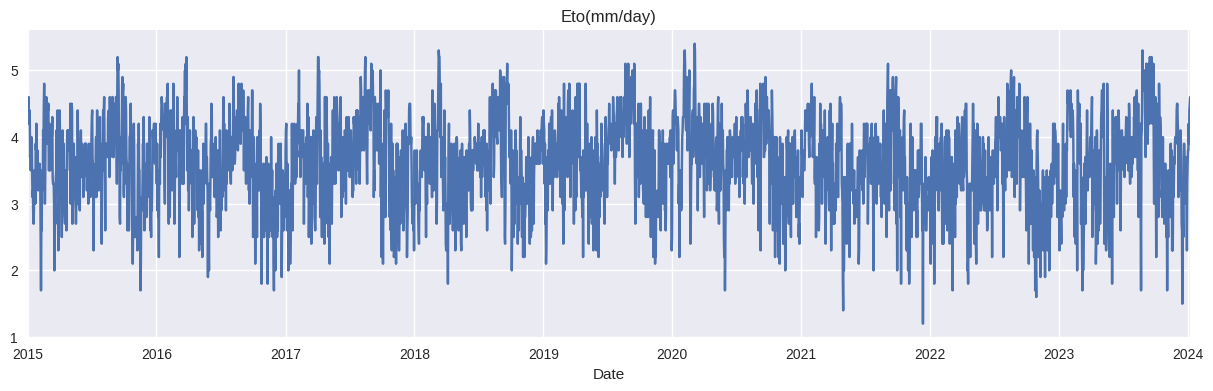

In [ ]:
from matplotlib import pyplot as plt
df_time_series_ETo['Eto(mm/day)'].plot(kind='line', figsize=(15, 4), title='Eto(mm/day)')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
print("Number of missing values: ", df_time_series_ETo.isnull().sum().sum())
print("Número de valores na: "),df_time_series_ETo.isna().sum()

Number of missing values:  0
Número de valores na: 


(None,
 Eto(mm/day)    0
 dtype: int64)

<ipython-input-13-23844f7fd7eb>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_time_series_ETo['Eto(mm/day)'])


<Axes: xlabel='Eto(mm/day)', ylabel='Density'>

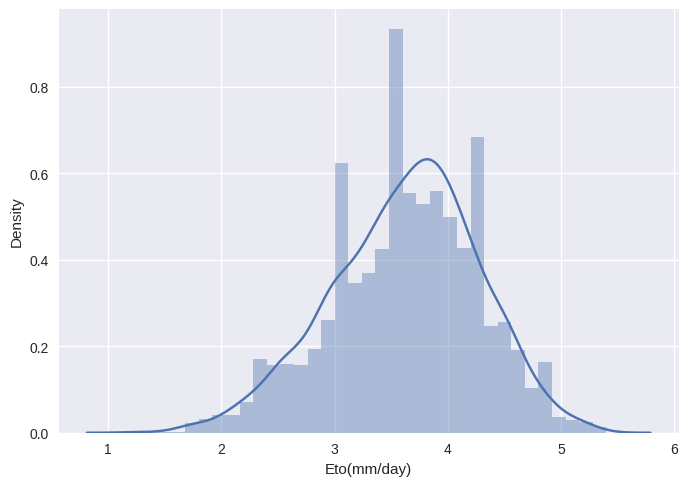

In [ ]:
sns.distplot(df_time_series_ETo['Eto(mm/day)'])

#Exploración del Conjunto de Datos

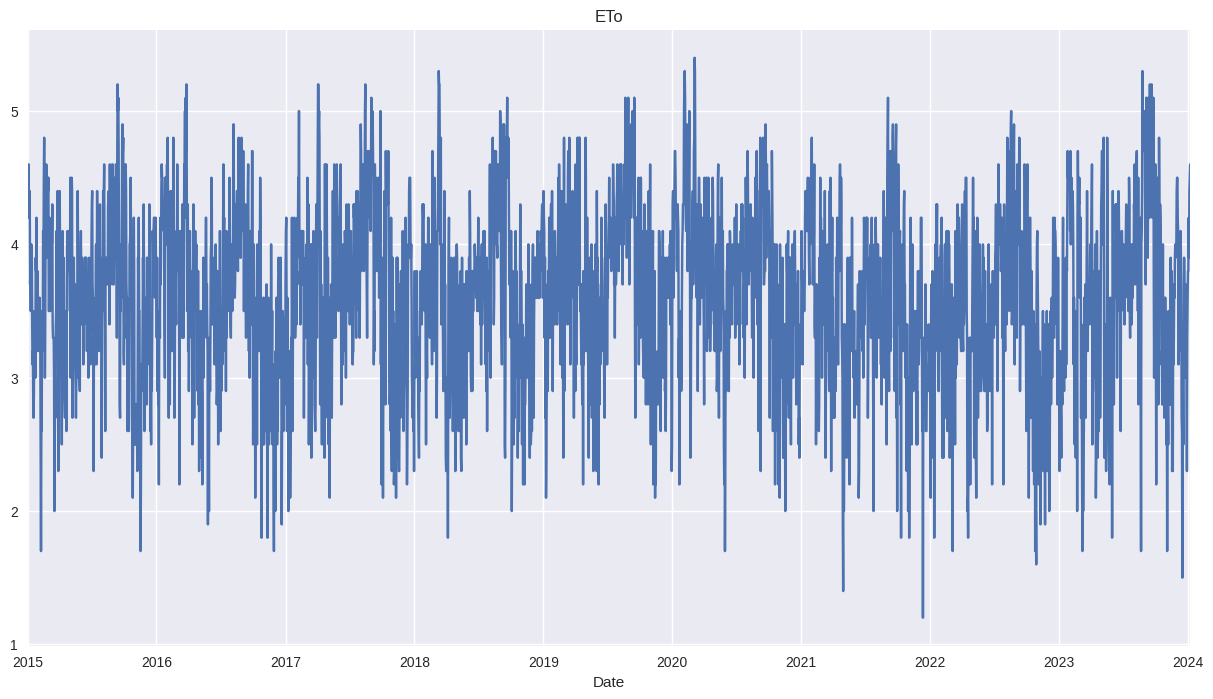

In [ ]:
df_time_series_ETo['Eto(mm/day)'].plot(kind='line', figsize=(15, 8), title='ETo')
plt.gca().spines[['top', 'right']].set_visible(False)

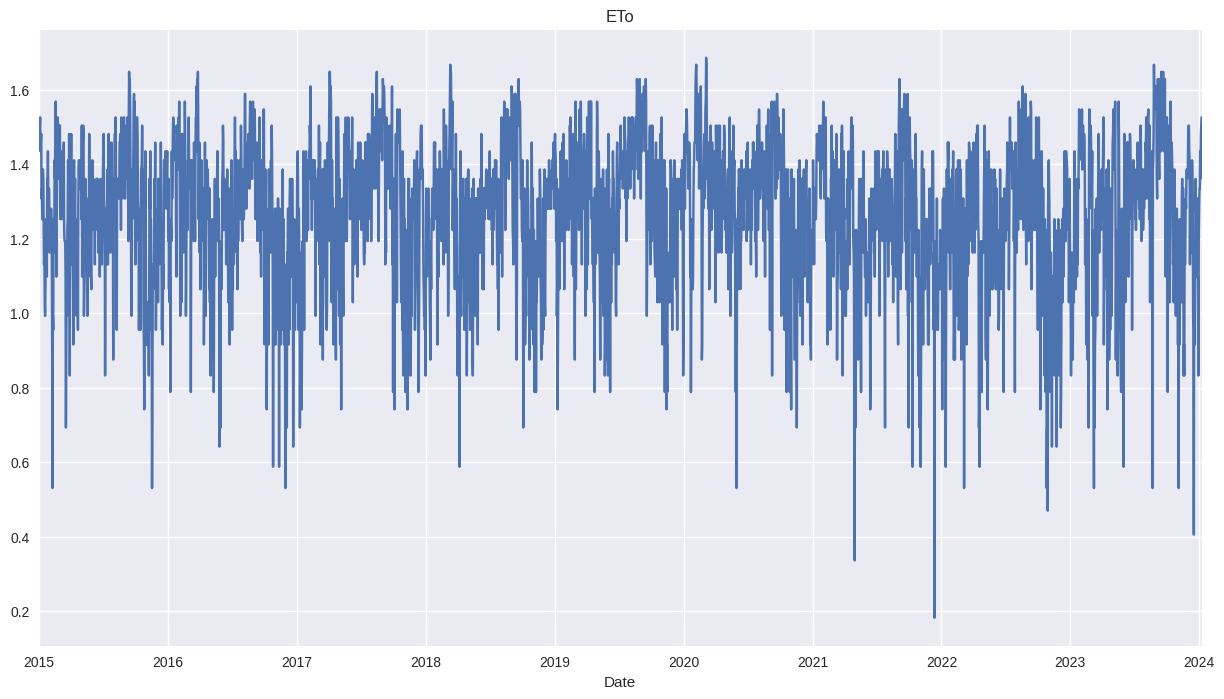

In [ ]:
df_time_series_ETo['ETo_log']= np.log(df_time_series_ETo['Eto(mm/day)'])
df_time_series_ETo['ETo_log'].plot(kind='line', figsize=(15, 8), title='ETo')
plt.gca().spines[['top', 'right']].set_visible(False)

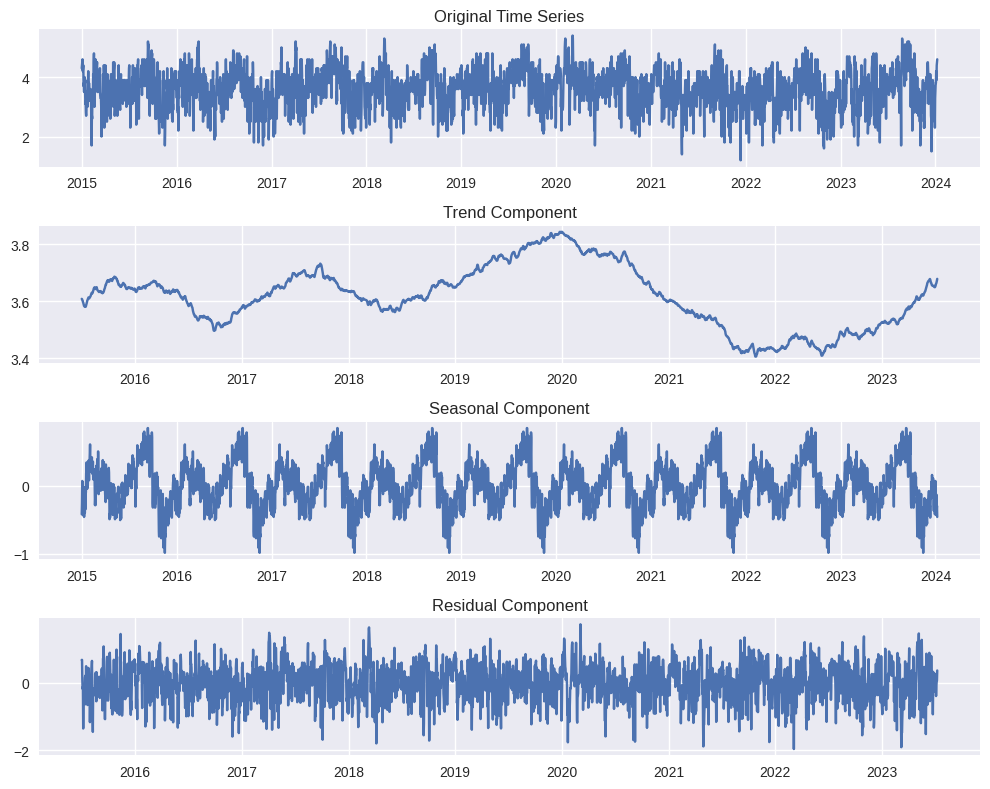

In [ ]:
df_time_series_ETo.index = pd.to_datetime(df_time_series_ETo.index)

# Perform seasonal decomposition
result = seasonal_decompose(df_time_series_ETo['Eto(mm/day)'], model='additive', period=365)

# Plot the components
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 8))

# Original time series
axes[0].plot(df_time_series_ETo.index, df_time_series_ETo['Eto(mm/day)'], label='Original')
axes[0].set_title('Original Time Series')

# Trend component
axes[1].plot(result.trend, label='Trend')
axes[1].set_title('Trend Component')

# Seasonal component
axes[2].plot(result.seasonal, label='Seasonal')
axes[2].set_title('Seasonal Component')

# Residual component
axes[3].plot(result.resid, label='Residual')
axes[3].set_title('Residual Component')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


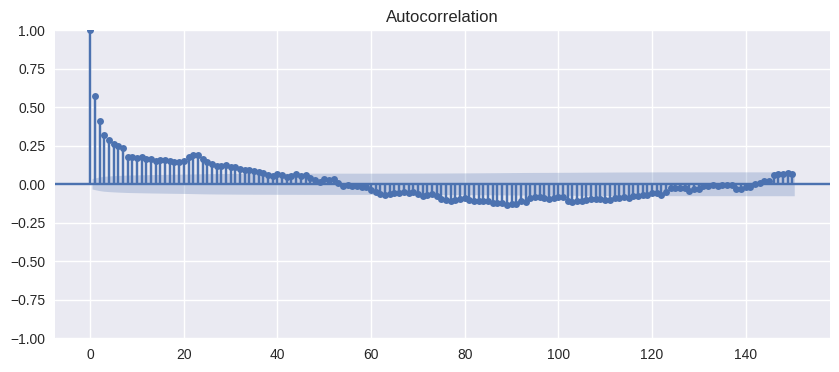

In [ ]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(df_time_series_ETo['Eto(mm/day)'], ax=ax, lags=150)
plt.show()

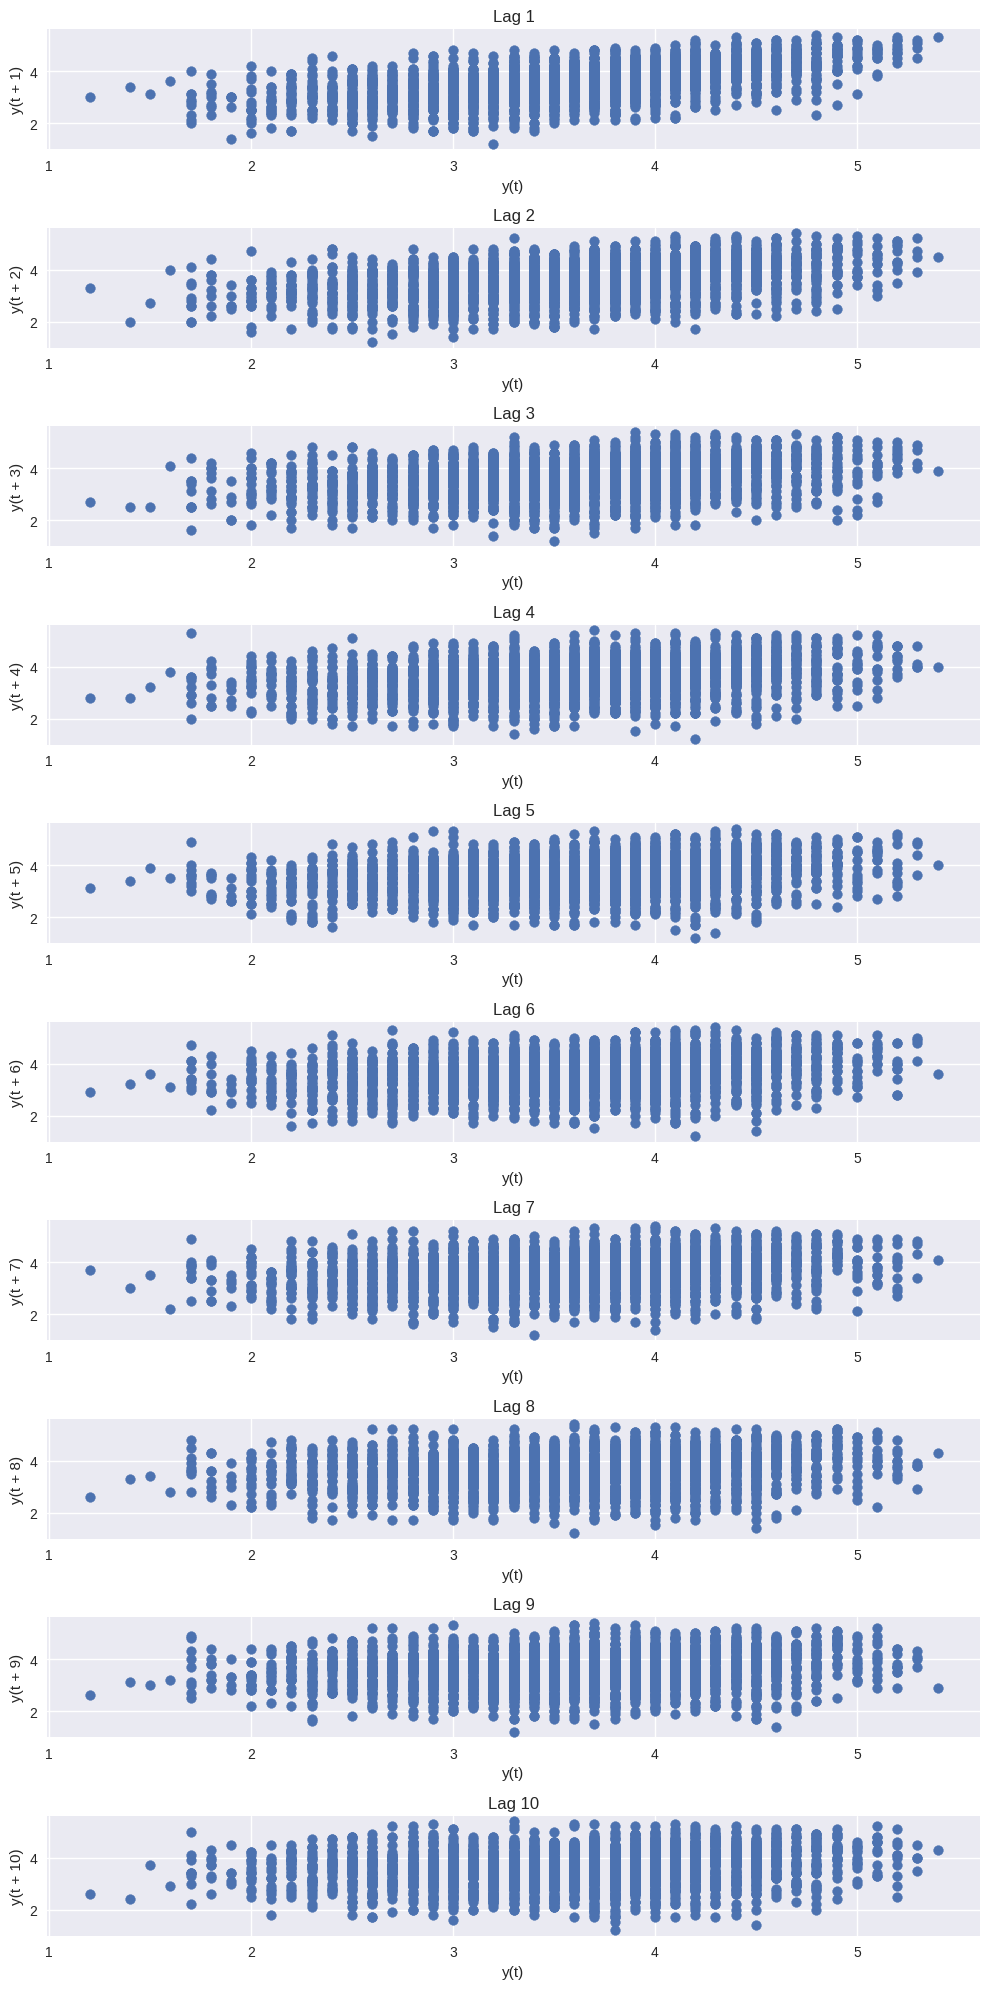

In [ ]:
# Generate lag plots for the first 10 lags
lags = 10

# Create subplots
fig, axes = plt.subplots(nrows=lags, ncols=1, figsize=(10, 2 * lags))

# Loop through the lags and plot each on a separate subplot
for lag in range(1, lags + 1):
    lag_plot(df_time_series_ETo['Eto(mm/day)'], lag=lag, ax=axes[lag - 1])
    axes[lag - 1].set_title(f'Lag {lag}')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

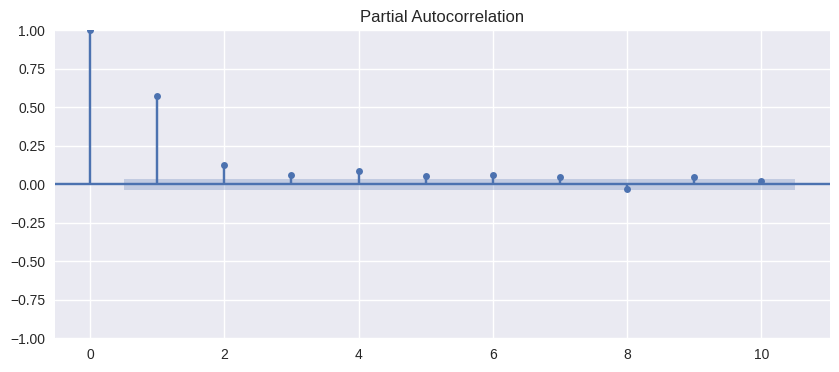

In [ ]:
# Partial autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 4))
plot_pacf(df_time_series_ETo['Eto(mm/day)'], ax=ax, lags=10, method='ywm')
plt.show()

In [ ]:
def adf_test(x):
    result = adfuller(x)
    pvalue= result[1]
    print(pvalue)
    if pvalue < 0.05:
        print("Estacionaria")
    else:
        print("NO estacionaria")

In [ ]:
adf_test(df_time_series_ETo['Eto(mm/day)'])

9.675368841412739e-10
Estacionaria


#Machine Learning

Dates train      : 2015-01-01 00:00:00 --- 2021-10-06 00:00:00  (n=2471)
Dates valid : 2021-10-07 00:00:00 --- 2023-02-12 00:00:00  (n=494)
Dates test       : 2023-02-13 00:00:00 --- 2024-01-08 00:00:00  (n=330)


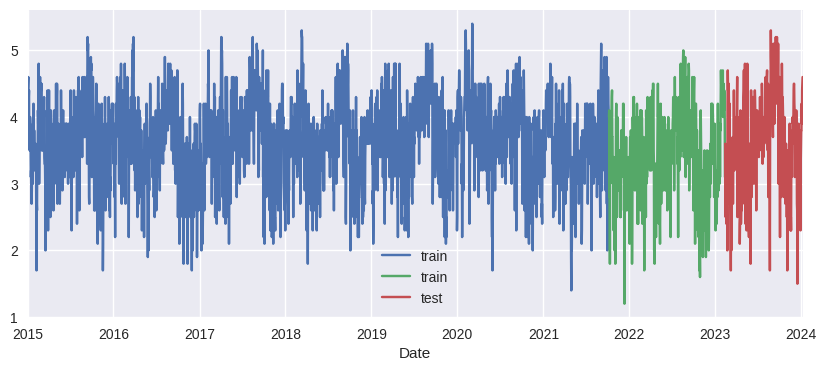

In [ ]:
samples_training = int(len(df_time_series_ETo) * 0.75)
samples_validation = int(len(df_time_series_ETo) * 0.15)
data_train = df_time_series_ETo.iloc[:samples_training]
data_valid = df_time_series_ETo.iloc[samples_training:samples_training + samples_validation]
data_test = df_time_series_ETo.iloc[samples_training + samples_validation:]
print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates valid : {data_valid.index.min()} --- {data_valid.index.max()}  (n={len(data_valid)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")
fig, ax = plt.subplots(figsize=(10, 4))
data_train['Eto(mm/day)'].plot(ax=ax, label='train')
data_valid['Eto(mm/day)'].plot(ax=ax, label='train')
data_test['Eto(mm/day)'].plot(ax=ax, label='test')
ax.legend();

##Modelo Base (Baseline)

In [ ]:
# Random walk simulation
# ==============================================================================
df_rw = df_time_series_ETo.copy()
df_rw['pred_ETo'] = df_rw['Eto(mm/day)'].shift(1)

# Test error
# ==============================================================================
end_train='2023-02-12'
y_true = df_rw.loc[end_train:, 'Eto(mm/day)']
y_pred = df_rw.loc[end_train:, 'pred_ETo']
metric = mean_absolute_error(y_true, y_pred)

print(f'Test error: {metric}')
display(df_rw.loc[end_train:,].tail(4))

Test error: 0.49969788519637454


,Eto(mm/day),ETo_log,pred_ETo
Date,,,
2024-01-05,3.9,1.360977,4.2
2024-01-06,4.4,1.481605,3.9
2024-01-07,4.5,1.504077,4.4
2024-01-08,4.6,1.526056,4.5


In [ ]:
print('MSE:',mean_squared_error(y_true,y_pred))
print('RMSE:',mean_squared_error(y_true,y_pred,squared=False))
print('MAPE:',mean_absolute_percentage_error(y_true,y_pred))
print('MAE:', mean_absolute_error(y_true,y_pred))

MSE: 0.4248942598187311
RMSE: 0.6518391364583221
MAPE: 0.15318786531104822
MAE: 0.49969788519637454


## LGBMRegressor

*Escenario* 1

In [ ]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=15926, verbose=-1),
                 lags      = 9
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=df_time_series_ETo.iloc[:samples_training + samples_validation, df_time_series_ETo.columns.get_loc('Eto(mm/day)')])
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=15926, verbose=-1) 
Lags: [1 2 3 4 5 6 7 8 9] 
Transformer for y: None 
Transformer for exog: None 
Window size: 9 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2015-01-01 00:00:00'), Timestamp('2023-02-12 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-04-19 23:49:15 
Last fit date

In [ ]:
predictions_LGMB= forecaster.predict(steps=len(data_test['Eto(mm/day)']))

In [ ]:
print('MSE:',mean_squared_error(data_test['Eto(mm/day)'],predictions_LGMB))
print('RMSE:',mean_squared_error(data_test['Eto(mm/day)'],predictions_LGMB,squared=False))
print('MAPE:',mean_absolute_percentage_error(data_test['Eto(mm/day)'],predictions_LGMB))
print('MAE:', mean_absolute_error(data_test['Eto(mm/day)'],predictions_LGMB))

MSE: 0.529917028417889
RMSE: 0.7279540015810676
MAPE: 0.1793716227329792
MAE: 0.5771831296237067


In [ ]:
# Backtest model on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = df_time_series_ETo['Eto(mm/day)'],
                          steps              = 3,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(df_time_series_ETo.iloc[:samples_training + samples_validation]),
                          refit              = False,
                          fixed_train_size   = False,
                          n_jobs             = 'auto',
                          verbose            = True, # Change to False to see less information
                          show_progress      = True
                      )

predictions.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 2965
Number of observations used for backtesting: 330
    Number of folds: 110
    Number of steps per fold: 3
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2015-01-01 00:00:00 -- 2023-02-12 00:00:00  (n=2965)
    Validation: 2023-02-13 00:00:00 -- 2023-02-15 00:00:00  (n=3)
Fold: 1
    Training:   2015-01-01 00:00:00 -- 2023-02-12 00:00:00  (n=2965)
    Validation: 2023-02-16 00:00:00 -- 2023-02-18 00:00:00  (n=3)
Fold: 2
    Training:   2015-01-01 00:00:00 -- 2023-02-12 00:00:00  (n=2965)
    Validation: 2023-02-19 00:00:00 -- 2023-02-21 00:00:00  (n=3)
Fold: 3
    Training:   2015-01-01 00:00:00 -- 2023-02-12 00:00:00  (n=2965)
    Validation: 2023-02-22 00:00:00 -- 2023-02-24 00:00:00  (n=3)
Fold: 4
    Training:   2015-01-01 00:00:00 -- 2023-02-12 00:00:00  (n=2965)
    Validation: 2023-02-25 00:00:00 

  0%|          | 0/110 [00:00<?, ?it/s]

,pred
2023-02-13,3.578001
2023-02-14,3.482954
2023-02-15,3.774415
2023-02-16,3.185977
2023-02-17,3.210027


In [ ]:
print('MSE:',mean_squared_error(data_test['Eto(mm/day)'],predictions))
print('RMSE:',mean_squared_error(data_test['Eto(mm/day)'],predictions,squared=False))
print('MAPE:',mean_absolute_percentage_error(data_test['Eto(mm/day)'],predictions))
print('MAE:', mean_absolute_error(data_test['Eto(mm/day)'],predictions))

MSE: 0.4285824324518575
RMSE: 0.6546620750065315
MAPE: 0.15932772638151368
MAE: 0.5204968209182133


Text(0.5, 1.0, 'Comparison of data_test and predictions')

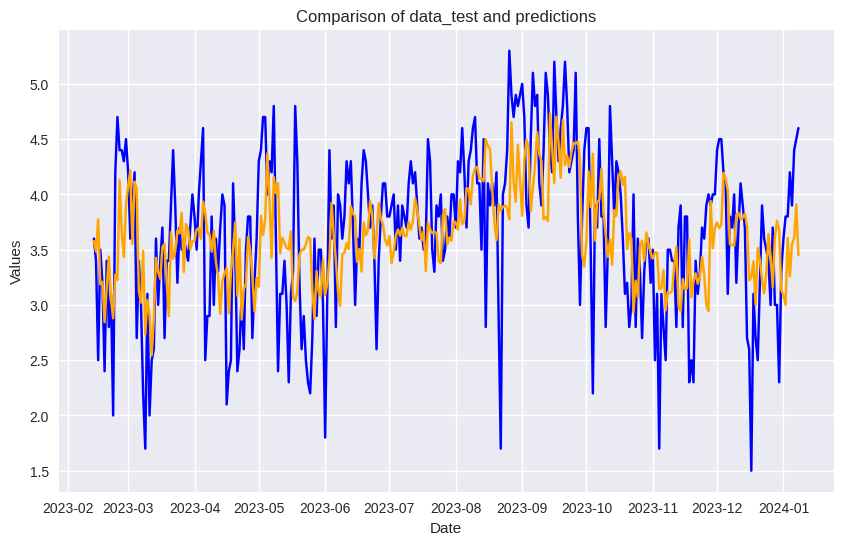

In [ ]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plotting data_test
plt.plot(data_test.index, data_test['Eto(mm/day)'], label='data_test', color='blue')

# Plotting predictions
plt.plot(predictions.index, predictions['pred'], label='predictions', color='orange')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Comparison of data_test and predictions')

Escenario 2, Hiperparametros usando conjunto de validación.

In [ ]:
# Hyperparameters search
# ==============================================================================
# Lags grid
lags_grid = [1,2,3,4,5,10,20,30,40,50,60]

# Regressor hyperparameters

param_distributions = {
    'max_depth': np.arange(start=-1, stop=10, step=1, dtype=int),
    'learning_rate'    : [0.001, 0.01, 0.1, 0.5],
    'n_estimators'     : [50,100,200, 500, 1000],
}


results_search = random_search_forecaster(
                                   forecaster         = forecaster,
                                   y                  = df_time_series_ETo.iloc[:samples_training + samples_validation, df_time_series_ETo.columns.get_loc('Eto(mm/day)')], # Test data not used
                                   steps                = 3,
                                   lags_grid            = lags_grid,
                                   param_distributions  = param_distributions,
                                   n_iter               = 10,
                                   metric               = 'mean_squared_error',
                                   refit                = False,
                                   initial_train_size   = len(df_time_series_ETo.iloc[:samples_training]),
                                   fixed_train_size     = False,
                                   return_best          = True,
                                   random_state         = 123,
                                   n_jobs               = 'auto',
                                   verbose              = False,
                                   show_progress        = True
                               )

Number of models compared: 110.


lags grid:   0%|          | 0/11 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50] 
  Parameters: {'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.01}
  Backtesting metric: 0.34263131149656073



In [ ]:
results_search.head(10)

,lags,params,mean_squared_error,n_estimators,max_depth,learning_rate
94,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1000, 'max_depth': 3, 'learni...",0.342631,1000.0,3.0,0.01
104,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1000, 'max_depth': 3, 'learni...",0.343242,1000.0,3.0,0.01
84,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1000, 'max_depth': 3, 'learni...",0.347583,1000.0,3.0,0.01
74,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1000, 'max_depth': 3, 'learni...",0.354606,1000.0,3.0,0.01
64,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1000, 'max_depth': 3, 'learni...",0.359089,1000.0,3.0,0.01
54,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'n_estimators': 1000, 'max_depth': 3, 'learni...",0.359285,1000.0,3.0,0.01
55,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'n_estimators': 1000, 'max_depth': 1, 'learni...",0.359571,1000.0,1.0,0.50
44,"[1, 2, 3, 4, 5]","{'n_estimators': 1000, 'max_depth': 3, 'learni...",0.360391,1000.0,3.0,0.01
105,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1000, 'max_depth': 1, 'learni...",0.362844,1000.0,1.0,0.50
65,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1000, 'max_depth': 1, 'learni...",0.363605,1000.0,1.0,0.50


In [ ]:
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(learning_rate=0.01, max_depth=3, n_estimators=1000,
              random_state=15926, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50] 
Transformer for y: None 
Transformer for exog: None 
Window size: 50 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2015-01-01 00:00:00'), Timestamp('2023-02-12 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.01, 'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 1000, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random

In [ ]:
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = df_time_series_ETo['Eto(mm/day)'],
                          steps              = 3,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(df_time_series_ETo.iloc[:samples_training + samples_validation]),
                          refit              = False,
                          fixed_train_size   = False,
                          n_jobs             = 'auto',
                          verbose            = True, # Change to False to see less information
                          show_progress      = True
                      )

predictions.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 2965
Number of observations used for backtesting: 330
    Number of folds: 110
    Number of steps per fold: 3
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2015-01-01 00:00:00 -- 2023-02-12 00:00:00  (n=2965)
    Validation: 2023-02-13 00:00:00 -- 2023-02-15 00:00:00  (n=3)
Fold: 1
    Training:   2015-01-01 00:00:00 -- 2023-02-12 00:00:00  (n=2965)
    Validation: 2023-02-16 00:00:00 -- 2023-02-18 00:00:00  (n=3)
Fold: 2
    Training:   2015-01-01 00:00:00 -- 2023-02-12 00:00:00  (n=2965)
    Validation: 2023-02-19 00:00:00 -- 2023-02-21 00:00:00  (n=3)
Fold: 3
    Training:   2015-01-01 00:00:00 -- 2023-02-12 00:00:00  (n=2965)
    Validation: 2023-02-22 00:00:00 -- 2023-02-24 00:00:00  (n=3)
Fold: 4
    Training:   2015-01-01 00:00:00 -- 2023-02-12 00:00:00  (n=2965)
    Validation: 2023-02-25 00:00:00 

  0%|          | 0/110 [00:00<?, ?it/s]

,pred
2023-02-13,3.579621
2023-02-14,3.606377
2023-02-15,3.659261
2023-02-16,3.257882
2023-02-17,3.428628


In [ ]:
print('MSE:',mean_squared_error(data_test['Eto(mm/day)'],predictions))
print('RMSE:',mean_squared_error(data_test['Eto(mm/day)'],predictions,squared=False))
print('MAPE:',mean_absolute_percentage_error(data_test['Eto(mm/day)'],predictions))
print('MAE:', mean_absolute_error(data_test['Eto(mm/day)'],predictions))

MSE: 0.38321797506829147
RMSE: 0.6190460201538263
MAPE: 0.14909023335964536
MAE: 0.4869445142740636


Guardar Modelo

In [ ]:
import pickle

In [ ]:
filename = 'modelo_ETo.pkl'
pickle.dump(forecaster, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open('modelo_ETo.pkl', 'rb'))

In [ ]:
last_window = df_time_series_ETo['Eto(mm/day)'].tail(50)

In [ ]:
input_data = (3)
prediction = loaded_model.predict(input_data,last_window=last_window)
print(prediction)

2024-01-09    4.090983
2024-01-10    3.883074
2024-01-11    3.778455
Freq: D, Name: pred, dtype: float64


Text(0.5, 1.0, 'Comparison of data_test and predictions')

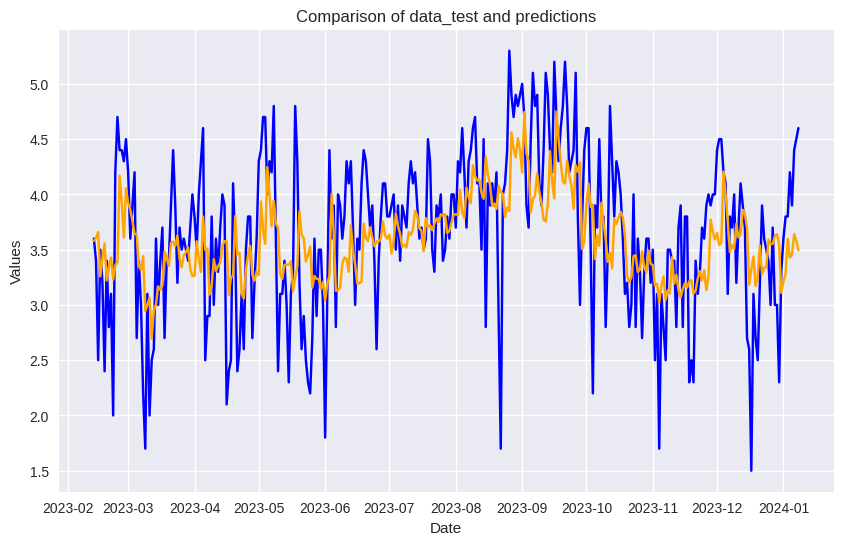

In [ ]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plotting data_test
plt.plot(data_test.index, data_test['Eto(mm/day)'], label='data_test', color='blue')

# Plotting predictions
plt.plot(predictions.index, predictions['pred'], label='predictions', color='orange')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Comparison of data_test and predictions')

Escenario 3, el backtesting usando refit con intermitencia de

In [ ]:
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = df_time_series_ETo['Eto(mm/day)'],
                          steps              = 3,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(df_time_series_ETo.iloc[:samples_training + samples_validation]),
                          allow_incomplete_fold = True,
                          refit              = 15,
                          fixed_train_size   = False,
                          n_jobs             = 'auto',
                          verbose            = True, # Change to False to see less information
                          show_progress      = True
                      )

predictions.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 2965
Number of observations used for backtesting: 330
    Number of folds: 110
    Number of steps per fold: 3
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2015-01-01 00:00:00 -- 2023-02-12 00:00:00  (n=2965)
    Validation: 2023-02-13 00:00:00 -- 2023-02-15 00:00:00  (n=3)
Fold: 1
    Training:   2015-01-01 00:00:00 -- 2023-02-12 00:00:00  (n=2965)
    Validation: 2023-02-16 00:00:00 -- 2023-02-18 00:00:00  (n=3)
Fold: 2
    Training:   2015-01-01 00:00:00 -- 2023-02-12 00:00:00  (n=2965)
    Validation: 2023-02-19 00:00:00 -- 2023-02-21 00:00:00  (n=3)
Fold: 3
    Training:   2015-01-01 00:00:00 -- 2023-02-12 00:00:00  (n=2965)
    Validation: 2023-02-22 00:00:00 -- 2023-02-24 00:00:00  (n=3)
Fold: 4
    Training:   2015-01-01 00:00:00 -- 2023-02-12 00:00:00  (n=2965)
    Validation: 2023-02-25 00:00:00 

  0%|          | 0/110 [00:00<?, ?it/s]

,pred
2023-02-13,3.579621
2023-02-14,3.606377
2023-02-15,3.659261
2023-02-16,3.257882
2023-02-17,3.428628


In [ ]:
print('MSE:',mean_squared_error(data_test['Eto(mm/day)'],predictions))
print('RMSE:',mean_squared_error(data_test['Eto(mm/day)'],predictions,squared=False))
print('MAPE:',mean_absolute_percentage_error(data_test['Eto(mm/day)'],predictions))
print('MAE:', mean_absolute_error(data_test['Eto(mm/day)'],predictions))

MSE: 0.39150203819253687
RMSE: 0.6257012371671777
MAPE: 0.15092695896296868
MAE: 0.4925025517023513



##Random Forest

In [ ]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 9
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=df_time_series_ETo.iloc[:samples_training + samples_validation, df_time_series_ETo.columns.get_loc('Eto(mm/day)')])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6 7 8 9] 
Transformer for y: None 
Transformer for exog: None 
Window size: 9 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2015-01-01 00:00:00'), Timestamp('2023-02-12 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-02-14 22:45:03 
Last fit date: 2024-02-14 22:45:05 
Skforecast version: 0.11.0 
Python vers

In [ ]:
predictions_RF= forecaster.predict(steps=len(data_test['Eto(mm/day)']))
print('MSE:',mean_squared_error(data_test['Eto(mm/day)'],predictions_RF))
print('RMSE:',mean_squared_error(data_test['Eto(mm/day)'],predictions_RF,squared=False))
print('MAPE:',mean_absolute_percentage_error(data_test['Eto(mm/day)'],predictions_RF))
print('MAE:', mean_absolute_error(data_test['Eto(mm/day)'],predictions_RF))

MSE: 0.5335760060606061
RMSE: 0.7304628711033888
MAPE: 0.182028761668229
MAE: 0.5690363636363636


In [ ]:
# Backtest model on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = df_time_series_ETo['Eto(mm/day)'],
                          steps              = 3,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(df_time_series_ETo.iloc[:samples_training + samples_validation]),
                          refit              = False,
                          fixed_train_size   = False,
                          n_jobs             = 'auto',
                          verbose            = True, # Change to False to see less information
                          show_progress      = True
                      )

predictions.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 2965
Number of observations used for backtesting: 330
    Number of folds: 110
    Number of steps per fold: 3
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2015-01-01 00:00:00 -- 2023-02-12 00:00:00  (n=2965)
    Validation: 2023-02-13 00:00:00 -- 2023-02-15 00:00:00  (n=3)
Fold: 1
    Training:   2015-01-01 00:00:00 -- 2023-02-12 00:00:00  (n=2965)
    Validation: 2023-02-16 00:00:00 -- 2023-02-18 00:00:00  (n=3)
Fold: 2
    Training:   2015-01-01 00:00:00 -- 2023-02-12 00:00:00  (n=2965)
    Validation: 2023-02-19 00:00:00 -- 2023-02-21 00:00:00  (n=3)
Fold: 3
    Training:   2015-01-01 00:00:00 -- 2023-02-12 00:00:00  (n=2965)
    Validation: 2023-02-22 00:00:00 -- 2023-02-24 00:00:00  (n=3)
Fold: 4
    Training:   2015-01-01 00:00:00 -- 2023-02-12 00:00:00  (n=2965)
    Validation: 2023-02-25 00:00:00 

  0%|          | 0/110 [00:00<?, ?it/s]

,pred
2023-02-13,3.500
2023-02-14,3.649
2023-02-15,3.576
2023-02-16,3.308
2023-02-17,3.456


In [ ]:
print('MSE:',mean_squared_error(data_test['Eto(mm/day)'],predictions))
print('RMSE:',mean_squared_error(data_test['Eto(mm/day)'],predictions,squared=False))
print('MAPE:',mean_absolute_percentage_error(data_test['Eto(mm/day)'],predictions))
print('MAE:', mean_absolute_error(data_test['Eto(mm/day)'],predictions))

MSE: 0.4136006545454545
RMSE: 0.6431179165172236
MAPE: 0.15373509395588333
MAE: 0.5078848484848485


Escenario 2

In [ ]:
# Hyperparameters search
# ==============================================================================
# Lags grid
lags_grid = [1,2,3,4,5,10,20,30,40,50,60]

# Regressor hyperparameters

param_distributions = {
    'n_estimators': np.arange(start=10, stop=150, step=1, dtype=int),
    'max_depth': [None, 3,5,10,20,30],
    'max_features': [1,3,5,7,9],
}


results_search = random_search_forecaster(
                                   forecaster         = forecaster,
                                   y                  = df_time_series_ETo.iloc[:samples_training + samples_validation, df_time_series_ETo.columns.get_loc('Eto(mm/day)')], # Test data not used
                                   steps                = 3,
                                   lags_grid            = lags_grid,
                                   param_distributions  = param_distributions,
                                   n_iter               = 10,
                                   metric               = 'mean_squared_error',
                                   refit                = False,
                                   initial_train_size   = len(df_time_series_ETo.iloc[:samples_training]),
                                   fixed_train_size     = False,
                                   return_best          = True,
                                   random_state         = 123,
                                   n_jobs               = 'auto',
                                   verbose              = False,
                                   show_progress        = True
                               )

Number of models compared: 110.


lags grid:   0%|          | 0/11 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60] 
  Parameters: {'n_estimators': 93, 'max_features': 9, 'max_depth': 30}
  Backtesting metric: 0.3481432974629535



In [ ]:
results_search.head(10)

,lags,params,mean_squared_error,n_estimators,max_features,max_depth
106,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 93, 'max_features': 9, 'max_d...",0.348143,93.0,9.0,30.0
101,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 104, 'max_features': 9, 'max_...",0.350573,104.0,9.0,20.0
107,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 119, 'max_features': 9, 'max_...",0.352233,119.0,9.0,30.0
91,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 104, 'max_features': 9, 'max_...",0.352617,104.0,9.0,20.0
86,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 93, 'max_features': 9, 'max_d...",0.353258,93.0,9.0,30.0
97,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 119, 'max_features': 9, 'max_...",0.354627,119.0,9.0,30.0
81,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 104, 'max_features': 9, 'max_...",0.356133,104.0,9.0,20.0
87,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 119, 'max_features': 9, 'max_...",0.356396,119.0,9.0,30.0
96,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 93, 'max_features': 9, 'max_d...",0.356639,93.0,9.0,30.0
61,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 104, 'max_features': 9, 'max_...",0.358525,104.0,9.0,20.0


In [ ]:
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=30, max_features=9, n_estimators=93,
                      random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60] 
Transformer for y: None 
Transformer for exog: None 
Window size: 60 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2015-01-01 00:00:00'), Timestamp('2023-02-12 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 30, 'max_features': 9, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimato

In [ ]:
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = df_time_series_ETo['Eto(mm/day)'],
                          steps              = 3,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(df_time_series_ETo.iloc[:samples_training + samples_validation]),
                          refit              = False,
                          fixed_train_size   = False,
                          n_jobs             = 'auto',
                          verbose            = True, # Change to False to see less information
                          show_progress      = True
                      )

predictions.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 2965
Number of observations used for backtesting: 330
    Number of folds: 110
    Number of steps per fold: 3
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2015-01-01 00:00:00 -- 2023-02-12 00:00:00  (n=2965)
    Validation: 2023-02-13 00:00:00 -- 2023-02-15 00:00:00  (n=3)
Fold: 1
    Training:   2015-01-01 00:00:00 -- 2023-02-12 00:00:00  (n=2965)
    Validation: 2023-02-16 00:00:00 -- 2023-02-18 00:00:00  (n=3)
Fold: 2
    Training:   2015-01-01 00:00:00 -- 2023-02-12 00:00:00  (n=2965)
    Validation: 2023-02-19 00:00:00 -- 2023-02-21 00:00:00  (n=3)
Fold: 3
    Training:   2015-01-01 00:00:00 -- 2023-02-12 00:00:00  (n=2965)
    Validation: 2023-02-22 00:00:00 -- 2023-02-24 00:00:00  (n=3)
Fold: 4
    Training:   2015-01-01 00:00:00 -- 2023-02-12 00:00:00  (n=2965)
    Validation: 2023-02-25 00:00:00 

  0%|          | 0/110 [00:00<?, ?it/s]

,pred
2023-02-13,3.723656
2023-02-14,3.594624
2023-02-15,3.688172
2023-02-16,3.393548
2023-02-17,3.337634


In [ ]:
print('MSE:',mean_squared_error(data_test['Eto(mm/day)'],predictions))
print('RMSE:',mean_squared_error(data_test['Eto(mm/day)'],predictions,squared=False))
print('MAPE:',mean_absolute_percentage_error(data_test['Eto(mm/day)'],predictions))
print('MAE:', mean_absolute_error(data_test['Eto(mm/day)'],predictions))

MSE: 0.4044272351982125
RMSE: 0.6359459373234587
MAPE: 0.15574759397574087
MAE: 0.5066422594527789


Escenario 3

In [ ]:
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = df_time_series_ETo['Eto(mm/day)'],
                          steps              = 3,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(df_time_series_ETo.iloc[:samples_training + samples_validation]),
                          allow_incomplete_fold = True,
                          refit              = 15,
                          fixed_train_size   = False,
                          n_jobs             = 'auto',
                          verbose            = True, # Change to False to see less information
                          show_progress      = True
                      )

predictions.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 2965
Number of observations used for backtesting: 330
    Number of folds: 110
    Number of steps per fold: 3
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2015-01-01 00:00:00 -- 2023-02-12 00:00:00  (n=2965)
    Validation: 2023-02-13 00:00:00 -- 2023-02-15 00:00:00  (n=3)
Fold: 1
    Training:   2015-01-01 00:00:00 -- 2023-02-12 00:00:00  (n=2965)
    Validation: 2023-02-16 00:00:00 -- 2023-02-18 00:00:00  (n=3)
Fold: 2
    Training:   2015-01-01 00:00:00 -- 2023-02-12 00:00:00  (n=2965)
    Validation: 2023-02-19 00:00:00 -- 2023-02-21 00:00:00  (n=3)
Fold: 3
    Training:   2015-01-01 00:00:00 -- 2023-02-12 00:00:00  (n=2965)
    Validation: 2023-02-22 00:00:00 -- 2023-02-24 00:00:00  (n=3)
Fold: 4
    Training:   2015-01-01 00:00:00 -- 2023-02-12 00:00:00  (n=2965)
    Validation: 2023-02-25 00:00:00 

  0%|          | 0/110 [00:00<?, ?it/s]

,pred
2023-02-13,3.723656
2023-02-14,3.594624
2023-02-15,3.688172
2023-02-16,3.393548
2023-02-17,3.337634


In [ ]:
print('MSE:',mean_squared_error(data_test['Eto(mm/day)'],predictions))
print('RMSE:',mean_squared_error(data_test['Eto(mm/day)'],predictions,squared=False))
print('MAPE:',mean_absolute_percentage_error(data_test['Eto(mm/day)'],predictions))
print('MAE:', mean_absolute_error(data_test['Eto(mm/day)'],predictions))

MSE: 0.3990124385638115
RMSE: 0.6316743136805639
MAPE: 0.15544044898244933
MAE: 0.5071457608750054
